In [1]:
import numpy as np

from ClassifierMetric.utils.plots import plot_class_score
from ClassifierMetric.datamodules.jetnet.datasets import JetNetDataset
from ClassifierMetric.datamodules.jetnet.dataloaders import JetNetDataLoader
from ClassifierMetric.utils.trainer import ModelClassifierTest

In [5]:
def evaluate_models(dir, Model, Config, device='cuda:0', tag=None):
    model_dir='/home/df630/ClassifierMetric/results/{}'.format(dir)
    config = Config.load(path=model_dir + "/configs.json")
    config.workdir = model_dir
    config.device = device
    config.tag = tag
    classifier = Model(model_config=config)
    datasets = JetNetDataset(dir_path = '/home/df630/ClassifierMetric/data/', 
                            datasets = config.datasets,
                            class_labels = config.labels,
                            num_jets = config.num_jets,
                            num_constituents = config.num_constituents,
                            preprocess = config.preprocess,
                            particle_features = config.features,
                            remove_negative_pt = True
                            ) 
    dataloader = JetNetDataLoader(datasets=datasets, data_split_fracs=config.data_split_fracs, batch_size=config.batch_size)
    classifier = ModelClassifierTest(classifier = classifier, 
                                    dataloader = dataloader,
                                    epochs = config.epochs, 
                                    lr = config.lr, 
                                    early_stopping = config.early_stopping,
                                    warmup_epochs = config.warmup_epochs,
                                    workdir = config.workdir,
                                    seed = config.seed)
    classifier.load_model(path=config.workdir + '/best_model.pth')
    classifier.test(class_labels=config.labels)
    return classifier, config

# ParticleNet classifier

In [3]:
from ClassifierMetric.models.particlenet import ParticleNet 
from ClassifierMetric.configs.particlenet_config import ParticleNetConfig

## jetnet30 [conditional models]

In [6]:
classifier, config = evaluate_models(dir="tops.ParticleNet_tops30_cond", 
                                     Model=ParticleNet,
                                     Config=ParticleNetConfig,
                                     device='cuda:0')

+------------------+---------------------------------------------------------------------------+
| Key              | Value                                                                     |
+------------------+---------------------------------------------------------------------------+
| data_name        | tops                                                                      |
| features         | ['eta_rel', 'phi_rel', 'pt_rel', 'e_rel', 'R']                            |
| preprocess       | ['standardize']                                                           |
| datasets         | flow_midpoint: ['fm_tops30_cond_mp200nfe.h5', 'etaphipt']                 |
|                  | diff_midpoint: ['diff_tops30_cond_midpoint_100_csts.h5', 'etaphipt_frac'] |
|                  | flow_euler: ['fm_tops30_cond_eu200nfe.h5', 'etaphipt']                    |
|                  | diff_euler: ['diff_tops30_cond_euler_200_csts.h5', 'etaphipt_frac']       |
|                  | diff_em: 

testing:   0%|          | 0/444 [00:00<?, ?it/s]

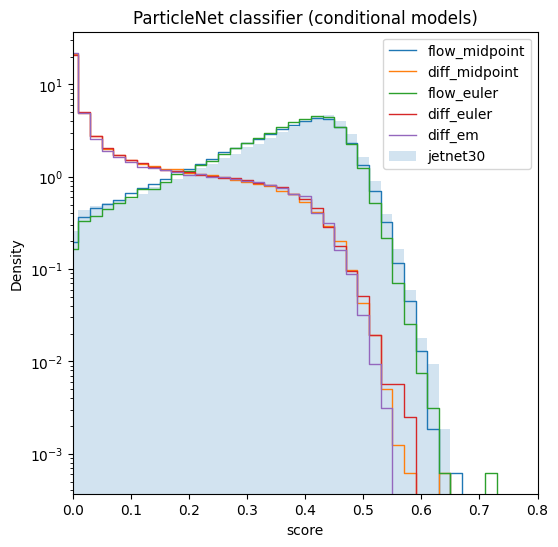

In [15]:
plot_class_score(predictions=classifier.predictions,
                class_labels=config.labels,
                reference='flow_midpoint',
                title='{} classifier (conditional models)'.format(config.model_name),
                figsize=(6,6), 
                xlim=(0,0.8),
                bins=np.arange(-0.03, 1.03, 0.02),
                workdir=config.workdir,
                density=True,
                lw =1,
                legend_loc='upper right')

In [31]:
import torch
torch.log(classifier.predictions['datasets'][..., :-1]).mean(dim=0)

tensor([-3.2890, -1.9863, -3.4506, -2.0125, -2.0609])

## jetnet30 [unconditional models]

In [16]:
classifier_1, config_1 = evaluate_models(dir="tops.ParticleNet_tops30_uncond", 
                                     Model=ParticleNet,
                                     Config=ParticleNetConfig,
                                     device='cuda:1'
                                     )

+------------------+----------------------------------------------------------------------+
| Key              | Value                                                                |
+------------------+----------------------------------------------------------------------+
| data_name        | tops                                                                 |
| features         | ['eta_rel', 'phi_rel', 'pt_rel', 'e_rel', 'R']                       |
| preprocess       | ['standardize']                                                      |
| datasets         | flow_midpoint: ['fm_tops30_mp200nfe.h5', 'etaphipt']                 |
|                  | diff_midpoint: ['diff_tops30_midpoint_100_csts.h5', 'etaphipt_frac'] |
|                  | flow_euler: ['fm_tops30_eu200nfe.h5', 'etaphipt']                    |
|                  | diff_euler: ['diff_tops30_euler_200_csts.h5', 'etaphipt_frac']       |
|                  | diff_em: ['diff_tops30_em_200_csts.h5', 'etaphipt_frac']   

testing:   0%|          | 0/444 [00:00<?, ?it/s]

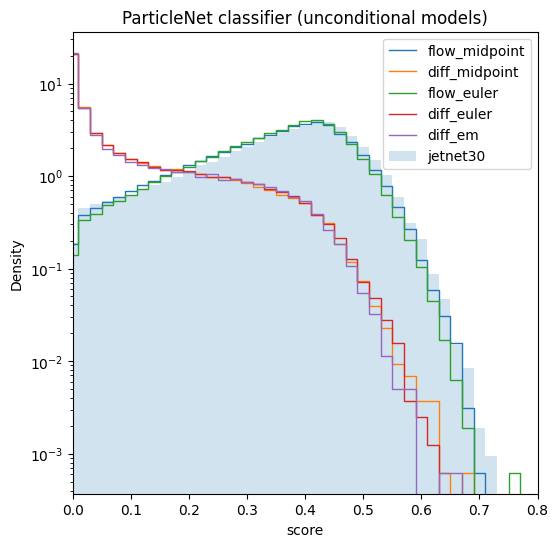

In [41]:
plot_class_score(predictions=classifier_1.predictions,
                class_labels=config_1.labels,
                reference='flow_midpoint',
                title='{} classifier (unconditional models)'.format(config_1.model_name),
                figsize=(6,6), 
                xlim=(0,0.8),
                bins=np.arange(-0.03, 1.03, 0.02),
                workdir=config_1.workdir,
                density=True,
                lw =1,
                legend_loc='upper right')

## jetnet30 [ODE midpoints]

In [33]:
classifier_2, config_2 = evaluate_models(dir="tops.ParticleNet_tops30_mp", 
                                     Model=ParticleNet,
                                     Config=ParticleNetConfig,
                                     device='cuda:1')

+------------------+--------------------------------------------------------------------------------+
| Key              | Value                                                                          |
+------------------+--------------------------------------------------------------------------------+
| data_name        | tops                                                                           |
| features         | ['eta_rel', 'phi_rel', 'pt_rel', 'e_rel', 'R']                                 |
| preprocess       | ['standardize']                                                                |
| datasets         | flow_midpoint_cond: ['fm_tops30_cond_mp200nfe.h5', 'etaphipt']                 |
|                  | diff_midpoint_cond: ['diff_tops30_cond_midpoint_100_csts.h5', 'etaphipt_frac'] |
|                  | flow_midpoint_uncond: ['fm_tops30_mp200nfe.h5', 'etaphipt']                    |
|                  | diff_midpoint_uncond: ['diff_tops30_midpoint_100_csts.h5', 'e

testing:   0%|          | 0/365 [00:00<?, ?it/s]

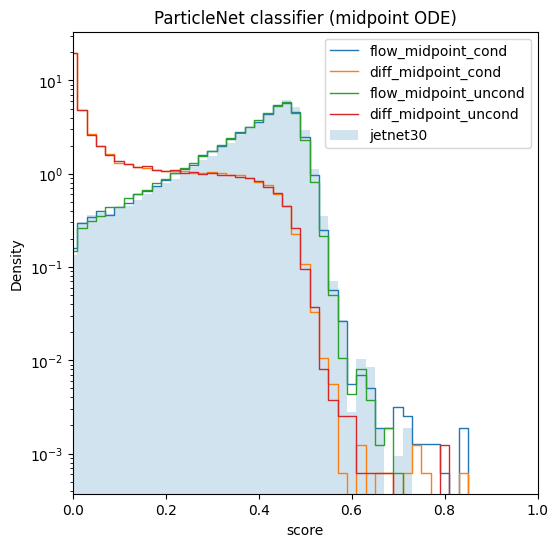

In [43]:
plot_class_score(predictions=classifier_2.predictions,
                class_labels=config_2.labels,
                reference='flow_midpoint_cond',
                title='{} classifier (midpoint ODE)'.format(config_2.model_name),
                figsize=(6,6), 
                xlim=(0,1),
                bins=np.arange(-0.03, 1.03, 0.02),
                workdir=config_2.workdir,
                density=True,
                lw =1,
                legend_loc='upper right')

## jetnet150 [conditional models]

In [51]:
classifier_3, config_3 = evaluate_models(dir="ParticleNet.tops.150_2023-08-10_07-15-11", 
                                     Model=ParticleNet,
                                     Config=ParticleNetConfig,
                                     device='cuda:1')

+------------------+----------------------------------------------------------------------------+
| Key              | Value                                                                      |
+------------------+----------------------------------------------------------------------------+
| data_name        | tops                                                                       |
| features         | ['eta_rel', 'phi_rel', 'pt_rel', 'e_rel', 'R']                             |
| preprocess       | ['standardize']                                                            |
| datasets         | flow_midpoint: ['fm_tops150_cond_mp200nfe.h5', 'etaphipt']                 |
|                  | diff_midpoint: ['diff_tops150_cond_midpoint_100_csts.h5', 'etaphipt_frac'] |
|                  | flow_euler: ['fm_tops150_cond_eu200nfe.h5', 'etaphipt']                    |
|                  | diff_euler: ['diff_tops150_cond_euler_200_csts.h5', 'etaphipt_frac']       |
|                  |

testing:   0%|          | 0/444 [00:00<?, ?it/s]

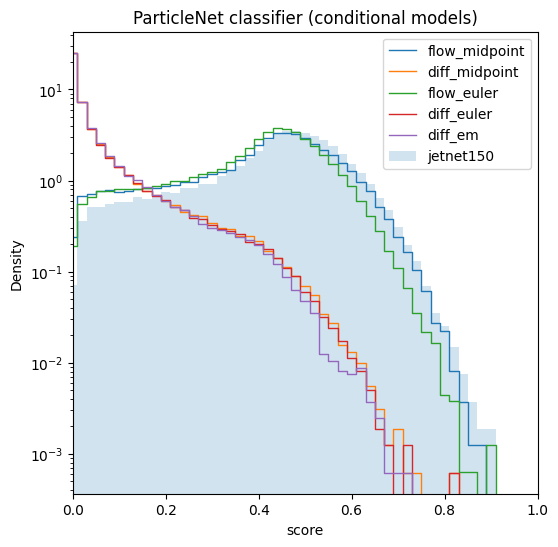

In [52]:
plot_class_score(predictions=classifier_3.predictions,
                class_labels=config_3.labels,
                reference='flow_midpoint',
                title='{} classifier (conditional models)'.format(config_3.model_name),
                figsize=(6,6), 
                xlim=(0,1),
                bins=np.arange(-0.03, 1.03, 0.02),
                workdir=config_3.workdir,
                density=True,
                lw =1,
                legend_loc='upper right')

## jetnet150 [unconditional models]

In [ ]:
classifier_4, config_4 = evaluate_models(dir="tops.ParticleNet_tops150_uncond", 
                                     Model=ParticleNet,
                                     Config=ParticleNetConfig,
                                     device='cuda:1')

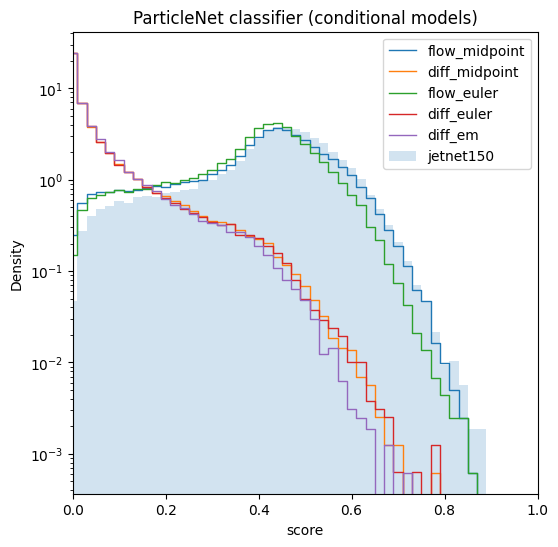

In [46]:
plot_class_score(predictions=classifier_4.predictions,
                class_labels=config_4.labels,
                reference='flow_midpoint',
                title='{} classifier (unconditional models)'.format(config_4.model_name),
                figsize=(6,6), 
                xlim=(0,1),
                bins=np.arange(-0.03, 1.03, 0.02),
                workdir=config_4.workdir,
                density=True,
                lw =1,
                legend_loc='upper right')

In [47]:
classifier_5, config_5 = evaluate_models(dir="tops.ParticleNet_tops150_mp", 
                                     Model=ParticleNet,
                                     Config=ParticleNetConfig,
                                     device='cuda:1')

+------------------+---------------------------------------------------------------------------------+
| Key              | Value                                                                           |
+------------------+---------------------------------------------------------------------------------+
| data_name        | tops                                                                            |
| features         | ['eta_rel', 'phi_rel', 'pt_rel', 'e_rel', 'R']                                  |
| preprocess       | ['standardize']                                                                 |
| datasets         | flow_midpoint_cond: ['fm_tops150_cond_mp200nfe.h5', 'etaphipt']                 |
|                  | diff_midpoint_cond: ['diff_tops150_cond_midpoint_100_csts.h5', 'etaphipt_frac'] |
|                  | flow_midpoint_uncond: ['fm_tops150_mp200nfe.h5', 'etaphipt']                    |
|                  | diff_midpoint_uncond: ['diff_tops150_midpoint_100_cs

testing:   0%|          | 0/365 [00:00<?, ?it/s]

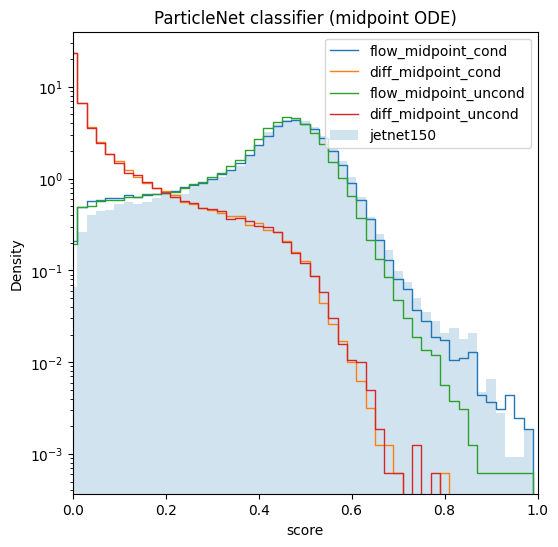

In [49]:
plot_class_score(predictions=classifier_5.predictions,
                class_labels=config_5.labels,
                reference='flow_midpoint_cond',
                title='{} classifier (midpoint ODE)'.format(config_5.model_name),
                figsize=(6,6), 
                xlim=(0,1),
                bins=np.arange(-0.03, 1.03, 0.02),
                workdir=config_5.workdir,
                density=True,
                lw =1,
                legend_loc='upper right')